<a href="https://colab.research.google.com/github/sosmany1/RNN_Parity-Problem/blob/master/TestingGeneralization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensor("ExpandDims_10122:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10123:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10124:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10128:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10129:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10130:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10131:0", shape=(4, 1), dtype=float32)
Tensor("ExpandDims_10132:0", shape=(4, 1), dtype=float32)


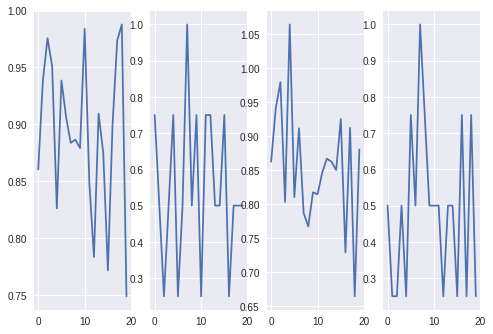

In [0]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math


num_epochs = 20 
total_series_length = 3
total_series_length_long = 5
state_size = 20 
num_classes = 1 
batch_size = 4 
_learning_rate = 1e-2

        
def generateData(_total_series_length):
    x = 1.0-2*(np.random.randn(batch_size,_total_series_length) < 0).astype(np.float32) 
    y = np.zeros((batch_size,_total_series_length),np.float32) 
    for i in range(_total_series_length):
      y[:, i] = np.prod(x[:,0:(i+1)],axis=1)
        
    x = x.reshape((batch_size, -1))  
    y = y.reshape((batch_size, -1))
    #print (x)
    #print (y)
    return x, y

W = tf.Variable(tf.truncated_normal([2, state_size], stddev=1.0 / math.sqrt(float(2))), name='weights1')
b = tf.Variable(tf.zeros([state_size]),name='biases1')
W2 = tf.Variable(tf.truncated_normal([state_size, 1], stddev=1.0 / math.sqrt(float(state_size))), name='weights2')
b2 = tf.Variable(tf.zeros([1]),name='biases2')


batchX_placeholder = tf.placeholder(tf.float32, [batch_size, total_series_length]) 
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, total_series_length]) 

batchX_placeholder_long = tf.placeholder(tf.float32, [batch_size, total_series_length_long]) 
batchY_placeholder_long = tf.placeholder(tf.float32, [batch_size, total_series_length_long]) 

def model(Xpc,Ypc,total_series_length):

  inputs_series = tf.unstack(value=Xpc, axis=1, num=total_series_length) 
  labels_series = tf.unstack(value=Ypc, axis=1, num=total_series_length) 

  inputs_series = [tf.expand_dims(current_input,axis=1) for current_input in inputs_series]
  labels_series = [tf.expand_dims(current_label, axis=1) for current_label in labels_series]



  prev_logit = tf.ones([batch_size, 1])
  states_series = []
  logits_series = []
  for current_input in inputs_series:
      print(current_input)

      current_input = tf.reshape(current_input, [batch_size, 1])
      prev_logit = tf.reshape(prev_logit, [batch_size, 1])
      input_and_state_concatenated = tf.concat([current_input, prev_logit],1) 

      next_state = tf.nn.relu(tf.matmul(input_and_state_concatenated, W) + b)  
      states_series.append(next_state)    

      prev_logit = tf.matmul(next_state, W2) + b2 
      logits_series.append(prev_logit)


  losses = [(tf.reduce_mean(tf.nn.relu(1.0 - logits*labels))) for logits, labels in zip(logits_series,labels_series) ]  
  total_loss = tf.reduce_mean(losses)

  train_step = tf.train.GradientDescentOptimizer(learning_rate=_learning_rate).minimize(total_loss)

  iscorrect = tf.cast(labels_series[-1]*logits_series[-1]>0,tf.float32)
  accuracy = tf.reduce_mean(iscorrect)
  return total_loss,accuracy,train_step

total_loss,accuracy,train_step = model(batchX_placeholder,batchY_placeholder,total_series_length)
total_loss_long,accuracy_long,_ = model(batchX_placeholder_long,batchY_placeholder_long,total_series_length_long)


init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)

    loss_list = []#
    accuracy_list = []
    
    loss_list_train = []#
    accuracy_list_train = []
    
    for epoch_idx in range(num_epochs):
      
      x,y = generateData(total_series_length)
      _, _acctrain, _losstrain = sess.run(
          [train_step, accuracy, total_loss],
          feed_dict={
              batchX_placeholder:x,
              batchY_placeholder:y
          })
      
      loss_list_train.append(_losstrain)
      accuracy_list_train.append(_acctrain)
      
      #print("Step",epoch_idx, "Accuracy Last Time Step", _acc)
      #GENERALITY!!!test on new data
      #plt.ion()#
      #plt.figure()#
      #plt.show()#

      x,y = generateData(total_series_length_long)
      _total_loss, _acc = sess.run(
        [total_loss_long, accuracy_long],
        feed_dict={
            batchX_placeholder_long:x,
            batchY_placeholder_long:y
         })
    
      #print("Testing set Loss",_total_loss, "Accuracy Last Time Step", _acc)
      loss_list.append(_total_loss)
      #print (total_loss)
      accuracy_list.append(_acc)


plt.subplot(1, 4, 1)
plt.plot(loss_list)
plt.subplot(1, 4, 2)
plt.plot(accuracy_list)
plt.subplot(1, 4, 3)
plt.plot(loss_list_train)
plt.subplot(1, 4, 4)
plt.plot(accuracy_list_train)
plt.ioff()
plt.show()
